# Лабораторная работа №5. Рябиков Илья

1. Сделайте симуляцию методом Монте-Карло вашего тикера США.
2. Задайте параметры опциона и посчитайте стоимость опциона на акцию вашей компаний на основе симуляций. Параметры опциона задайте сами. Торгуются ли опционы на акции вашей компании (Yahoo Finance).
3. Выберите один из опционов на индекс РТС. К примеру, https://www.moex.com/ru/contract.aspx?code=RI100000BK2D . Опишите основные параметры опциона
4. Рассчитайте стоимость этого опциона по модели BSM и методом Монте-Карло.
5. Сравнить результаты разных методов между собой и с рыночной ценой. Какие выводы можно сделать из этого сравнения?

## Импорт библиотек и данных

### Библиотеки

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install finam-export

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install QuantLib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
import requests
from finam import Exporter, Market, LookupComparator
import QuantLib as ql

### Данные по американской акции Майкрософт

In [ ]:
today = date.today()

# Get the data for the stock AAPL
df = yf.download('MSFT','2010-01-01', today)
df['log_rtn'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))

[*********************100%***********************]  1 of 1 completed


## Расчет показателей для MSFT

### Симуляция методом Монте Карло (сделаем Геометрическое Броуновское Движение)

Геометрическое броуновское движение — случайный процесс с непрерывным временем, логарифм которого представляет собой броуновское движение (Википедия). Оно удовлетворяет стохастическому уравнению, связывающему изменение цены актива с такими показателями, как изменение времени, ожидаемая доходность, СКО и само Броуновское Движение

In [ ]:
train = df.log_rtn[:'2022-10-01']
test = df.log_rtn['2022-10-01':]

Зададим коэффициенты для рассчета ГБД

In [ ]:
T = len(test) # Forecasting horizon; the number of days in the test set
N = len(test) #  Number of time increments in the forecasting horizon.
S_0 = df.iloc[len(train)-1].Close # starting price 
N_SIM = 200 # Number of simulated paths 
mu = train.mean() # mean 
sigma = train.std() # s.d
t = 12/365 # time till expirations
r = 0.04 # Безрисковая ставка - возьмем из семинара, поскольку и там и тут рынок США
discount_factor = np.exp(-r * t) 

Построим график окна волатильности в 20 дней

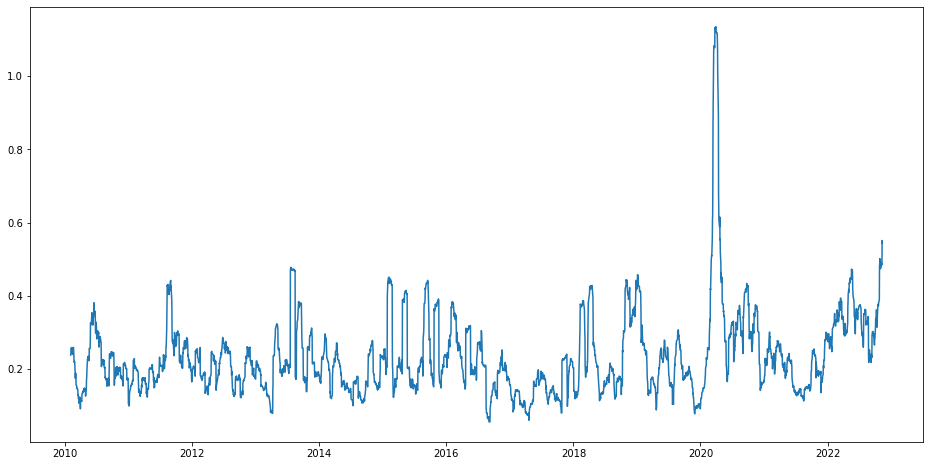

In [ ]:
rolling_std = df['log_rtn'].rolling(20).std()

fig = plt.figure(figsize=(16, 8))
ax = plt.axes()
ax.plot(rolling_std.index, rolling_std * np.sqrt(252))

Расчитаем симуляции ГБД (функция из семинара)

In [ ]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N):
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N)) # Brownian increment
    W = np.cumsum(dW, axis=1) # Browninan path

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps  + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    return S_t

In [ ]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

In [ ]:
LAST_TRAIN_DATE = train.index[-1].date()
FIRST_TEST_DATE = test.index[0].date()
LAST_TEST_DATE = test.index[-1].date()
PLOT_TITLE = "Simulation of stock price for MSFT"
selected_indices = df.Close[LAST_TRAIN_DATE:LAST_TEST_DATE].index
index = [date.date() for date in selected_indices]


In [ ]:
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), index=index)

И построим наши симуляции на графике

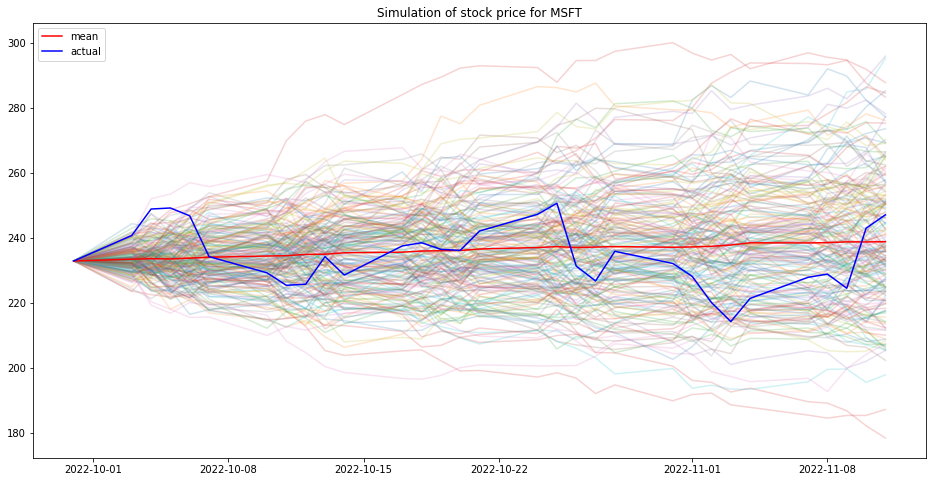

In [ ]:
# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False, figsize=(16, 8))
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1),
                  color='red')
line_2, = ax.plot(index, df.Close[LAST_TRAIN_DATE:LAST_TEST_DATE],color='blue')
ax.set_title(PLOT_TITLE, fontsize=12)
ax.legend((line_1, line_2), ('mean', 'actual'))


После 200 симуляций стоимость акций Майкрософт ожидается от где-то 180 до 300 долл. Реальная стоимость акции около 240 долл., а средняя стоимость по симуляциям где-то на 5 долларов меньше. Поскольку мы задавали симуляции исходя из реальных показателей акции, то закономерно, что они очень близки к друг другу, но благодаря ГБД мы смогли посмотреть возможные пути цены акций.

### Оценка опционов на акцию Майкрософт

Проведем симуляции для оценки цены Европейского опциона на акции Майкрософта. Цену страйк поставим 240

In [ ]:
N_SIMS = 10 ** 6 
K = 240 #strike price
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), index=index)
premium = discount_factor * np.average(np.maximum(0, gbm_simulations[:, -1] - K))
options = np.maximum(0, gbm_simulations[:, -1] - K)

Построим распределение цен опционов после симуляций

(array([128.,  18.,  15.,  14.,  11.,   8.,   3.,   2.,   0.,   1.]),
 array([ 0.        ,  6.95609444, 13.91218889, 20.86828333, 27.82437777,
        34.78047222, 41.73656666, 48.6926611 , 55.64875555, 62.60484999,
        69.56094444]),
 <a list of 10 Patch objects>)

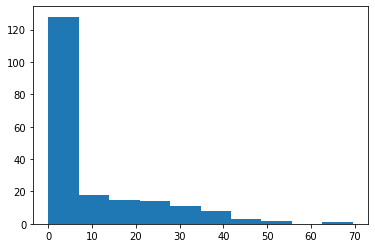

In [ ]:
plt.hist(options, bins=10)

Посмотрим на среднюю премию за опцион (скорректированную на время и ставку процента и нет)

In [ ]:
options.mean()

9.056403040780985

In [ ]:
premium

9.04450107814409

Премия для среднего по симуляциям опциона равна 9.04 доллара с корректировкой на время до экспирации и 9.05 без корректировки (они почти равны, поскольку дата экспирации будет буквально через 4 недели)

Посмотрим также, как распределяются цены симуляций относительно цены страйк

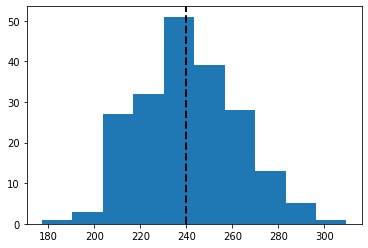

In [ ]:
last_price = gbm_simulations_df.tail(1)
plt.hist(last_price, bins=10)
plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")


Страйк немного левее пика по симуляциям - можно ожидать, что если мы имеем колл-опцион с таким страйком, то нам было бы не совсем выгодно, поскольку мы имеем право купить актив по большей цене, чем симуляции предсказывают нам наиболее ожидаемую цену(

Проверим, торгуются ли опционы на акицию Майкрософт. Предполагаю с очень высокой вероятностью, что да:

In [ ]:
MSFT = yf.Ticker("MSFT")
opt = MSFT.option_chain('2022-12-09')
df_opt = opt.calls
df_opt[df_opt['strike']==240]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
10,MSFT221209C00240000,2022-11-11 20:59:19+00:00,240.0,11.95,11.95,12.7,2.17,22.18814,508,1428,0.328742,True,REGULAR,USD


Как и ожидалось, опционы на Майкрософт конечно же торгуются на бирже. Цена опциона немного выше, чем получившийся методом симуляции среднее распределения цен опциона.

## Расчет цены опциона на индекс РТС

### Данные по опциону на индекс

Source: https://www.moex.com/ru/contract.aspx?code=RI100000BK2D 

In [ ]:
# parameters of on option
S_0 = 114970 # current price of the index
K = 100000 # Strike price
r = 0.07 # risk free rate для России
sigma = 0.46 #underlying  index volatility (annualized) https://www.moex.com/a2716
T = 12/365 # time until maturity (in years)

N = 105 # Number of time increments for simulations
dt = T / N # time step
discount_factor = np.exp(-r * T)

P_real = 14730 # реальная цена опциона

Основные свойства опциона:

1. цена страйк - 100000
2. текущая стоимость базового актива - 114970
3. Дата исполнения - 24.11.2022
4. Стоимость опциона перед выходными была 14730
5. Тип - call

### Black-Scholes Model

Первым делом найдем цену колл-опциона на фьючерс на индекс РТС методом Блэка-Шоулза

In [ ]:
from scipy.stats import norm

def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    d1 = (np.log(S_0/K) + (r + 0.5 * sigma**2) * T) /(sigma * np.sqrt(T))
    d2 = (np.log(S_0/K) + (r - 0.5 * sigma**2) * T) /(sigma * np.sqrt(T))
    if type == 'call':
        val = (S_0*norm.cdf(d1, 0, 1)-K*np.exp(-r*T) *norm.cdf(d2, 0, 1))
    elif type == 'put':
        val = (K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)-S_0 *norm.cdf(-d1, 0, 1))
    return val

In [ ]:
P_bsm = black_scholes_analytical(S_0=S_0, 
                         K=K, 
                         T=T, 
                         r=r,
                         sigma=sigma, 
                         type='call')

### Симуляции Monte Carlo

Далее найдем цену того же колл-опциона методом симуляций

In [ ]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
# gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), index=index)
premium = discount_factor * np.average(np.maximum(0, gbm_simulations[:, -1] - K))
options = np.maximum(0, gbm_simulations[:, -1] - K)

(array([35., 20., 31., 35., 29., 18., 19.,  7.,  2.,  4.]),
 array([    0.        ,  4352.77523246,  8705.55046492, 13058.32569739,
        17411.10092985, 21763.87616231, 26116.65139477, 30469.42662724,
        34822.2018597 , 39174.97709216, 43527.75232462]),
 <a list of 10 Patch objects>)

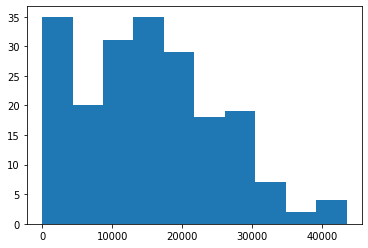

In [ ]:
plt.hist(options, bins=10)

 Сохраним среднюю цену опциона по методу симуляций Монте-Карло (экспирация буквально через 2 недели, поэтому умножение на discount rate почти никак не повлияет на премию

In [ ]:
P_mk = options.mean()

Итого, цены опциона разными методами:

In [ ]:
print(f"Фактический: {P_real}, Метод Блэка-Скоулза: {round(P_bsm)}, Симуляции Монте Карло: {round(P_mk)}")

Фактический: 14730, Метод Блэка-Скоулза: 15518, Симуляции Монте Карло: 15288


Фактическая цена опциона оказалась немного ниже, чем полученная двумя методами, но между методами и реальной ценой разница не настолько большая, и составляет где-то 1%. Такая разница между фактической и расчетной ценой возможно обусловлена скорым исполнением опциона, и рыночной ситуацией. 

## Вывод

Таким образом, были построены симуляции стоимости акций компании Майкрософт. Распределение симуляций лежит довольно таки близко к реальной стоимости акций, но это обусловлено тем, что при построении симуляций мы использовали реальные среднее и волатильность, но данные расчеты помогли посмотреть, как могли двигаться цены акции. 

Далее эти симуляции были использованы для расчета опционов на акцию Майкрософт, и полученная цена оказалась близкой к реальной стоимости опциона с таким же страйком (9 и 11 долларов соотвественно).

Следующим пунктом был расчет стоимости опциона на фьючерс на индекс РТС. Вначале были описаны свойства этого опциона, затем были проведены симуляции и расчет методом Блэка-Скоулза цены опциона на фьючерс РТС. Цены опциона, полученные этими двумя методами получились немного выше, чем реальная цена опциона, но довольно близки между собой. Это отставание реальной цены от цен симуляций может обуславливаться текущей ситуацицей на рынке - инвесторы боятся покупать колл опционы, поскольку многие избавляются от активов, и соотвественно спрос на опцион ниже и цена ниже расчетной.  